In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools
from tqdm import tqdm
from scipy import stats
from geolite2 import geolite2 
%config InlineBackend.figure_format = 'retina' 

## Miner-worker relationships on the Filecoin network

B. H. Tan

In this notebook I explore the miner-worker relationships on the Filecoin network by tracking chain data. 

In [3]:
def plot_geolocated_subgraphs(df, show_labels=False, n_rows=4, node_size=27):
    '''
    Plot subgraphs for which there is at least one successfully geolocated node.
    
    df (pd.DataFrame): original dataframe
    show_labels (bool): display actor ID or not
    n_rows (int): number of rows in the plot
    '''
    subgraphs = [nx.subgraph(G,c) for c in nx.connected_components(G)]
    
    fig, axs = plt.subplots(n_rows, n_rows, figsize=(12,12))

    graphs_drawn = 0
    t = tqdm(range(len(subgraphs)))
    for idx in t:
        k = subgraphs[idx]
        country_list = []
        label_dict = {}

        t.set_description('Searching %s nodes' % len(k.nodes))

        # Find out how many countries have been geolocated in this subgraph

        if len(k.nodes) < 500: # don't bother plotting if there are a lot of nodes
            pos = nx.spring_layout(k)
            for i, node in enumerate(k.nodes):
                if i >= 500: # stop searching after X nodes
                    break
                if len(df[df.miner_id==node]) > 0:
                    ctry = df[df.miner_id==node]['country'].values[0]
                    if ctry is not np.nan:
                        country_list.append(ctry)
                        break
                        
            if len(country_list) > 0 and country_list[0] != np.nan:
                color_map = []
                for node in k.nodes:
                    if node in df.miner_id.values:
                        color_map.append('C3')
                    else:
                        if node in df.owner_id.values:
                            color_map.append('C2')
                        else:
                            color_map.append('C0')

                ax = axs.ravel()[graphs_drawn]
                country_list = []
                for node in k.nodes:
                    if len(df[df.miner_id==node]) > 0:
                        ctry = df[df.miner_id==node]['country'].values[0]
                        if ctry is not np.nan:
                            country_list.append(ctry)
                            label_dict[node] = ctry

                if country_list == []:
                    ax.set_title('%s (%s nodes)' % (idx,len(k.nodes)))
                else:
                    nx.draw_networkx_nodes(k, pos, node_color=color_map, ax=ax)
                    nx.draw_networkx_edges(k, pos, ax=ax)
                    nx.draw_networkx_labels(k, pos, label_dict, ax=ax, font_color='white')
                    ax.set_title('%s (%s nodes; %s g.l. from %s)' % (idx,len(k.nodes), len(country_list), list(set(country_list)))  )
        
                graphs_drawn += 1
        
        if graphs_drawn >= n_rows**2: 
            plt.suptitle('Geolocated subnetworks / miner (red), owner (green), worker (blue)')
            plt.tight_layout()    
            return

            


### 0. Perform geolocation on the miner network



The raw data is extracted from Lily, using this SQL query

```
    select distinct
        miner_id,
        owner_id,
        worker_id,
        control_addresses,
        multi_addresses
    from miner_infos
```

There are numerous ways to perform the IP lookup, but a simple and fast option on Python is to use the `geolite2` package.

In [4]:
# 0. Preliminaries
# 0a. Load lookup database
geo = geolite2.reader()

def extract_country(x):
    out = np.nan
    try:
        # out = geo.get(x)['country']['names']['en']
        out = geo.get(x)['country']['iso_code']
    except:
        pass
    return out

# 0b. Load worker relationship data
data = pd.read_csv('../data/worker_relationship_jun_20.csv', index_col=[0])
dsplt = data['multi_addresses'].str.split('/', expand=True)
dsplt = dsplt[dsplt.columns[2]]
data['ip'] = dsplt
del dsplt

# 0c. Extract country
data['country'] = data['ip'].apply(extract_country)

# 1. Load network
# 1a. Add edges
G = nx.Graph()
for m,c in zip(data.miner_id, data.country):
    G.add_node(m, country=c)
G.add_edges_from([mi, wi] for mi, wi in data[['miner_id', 'worker_id']].drop_duplicates().values)
G.add_edges_from([mi, oi] for mi, oi in data[['miner_id', 'owner_id']].drop_duplicates().values)

# 1b. Remove small components
small_components = sorted(nx.connected_components(G), key=len)[:-800]
G.remove_nodes_from(itertools.chain.from_iterable(small_components))


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 615216 entries, 0 to 615215
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   miner_id           615216 non-null  object
 1   owner_id           615216 non-null  object
 2   worker_id          615216 non-null  object
 3   control_addresses  19433 non-null   object
 4   multi_addresses    11075 non-null   object
 5   ip                 11075 non-null   object
 6   country            9600 non-null    object
dtypes: object(7)
memory usage: 37.5+ MB


### 1. Plot geolocated subnetworks

Using `networkx` we successively add nodes and edges to a network. Nodes start from `miner_id` and end at `owner_id` or `worker_id`. Note that only `miner_ids` have IP addresses (which are defined on chain by `multi_addresses`). Note that the network is not fully connected as not all miners/owners/workers will connect to one another. 

Searching 50 nodes:   2%|▏         | 12/800 [00:20<22:45,  1.73s/it] 


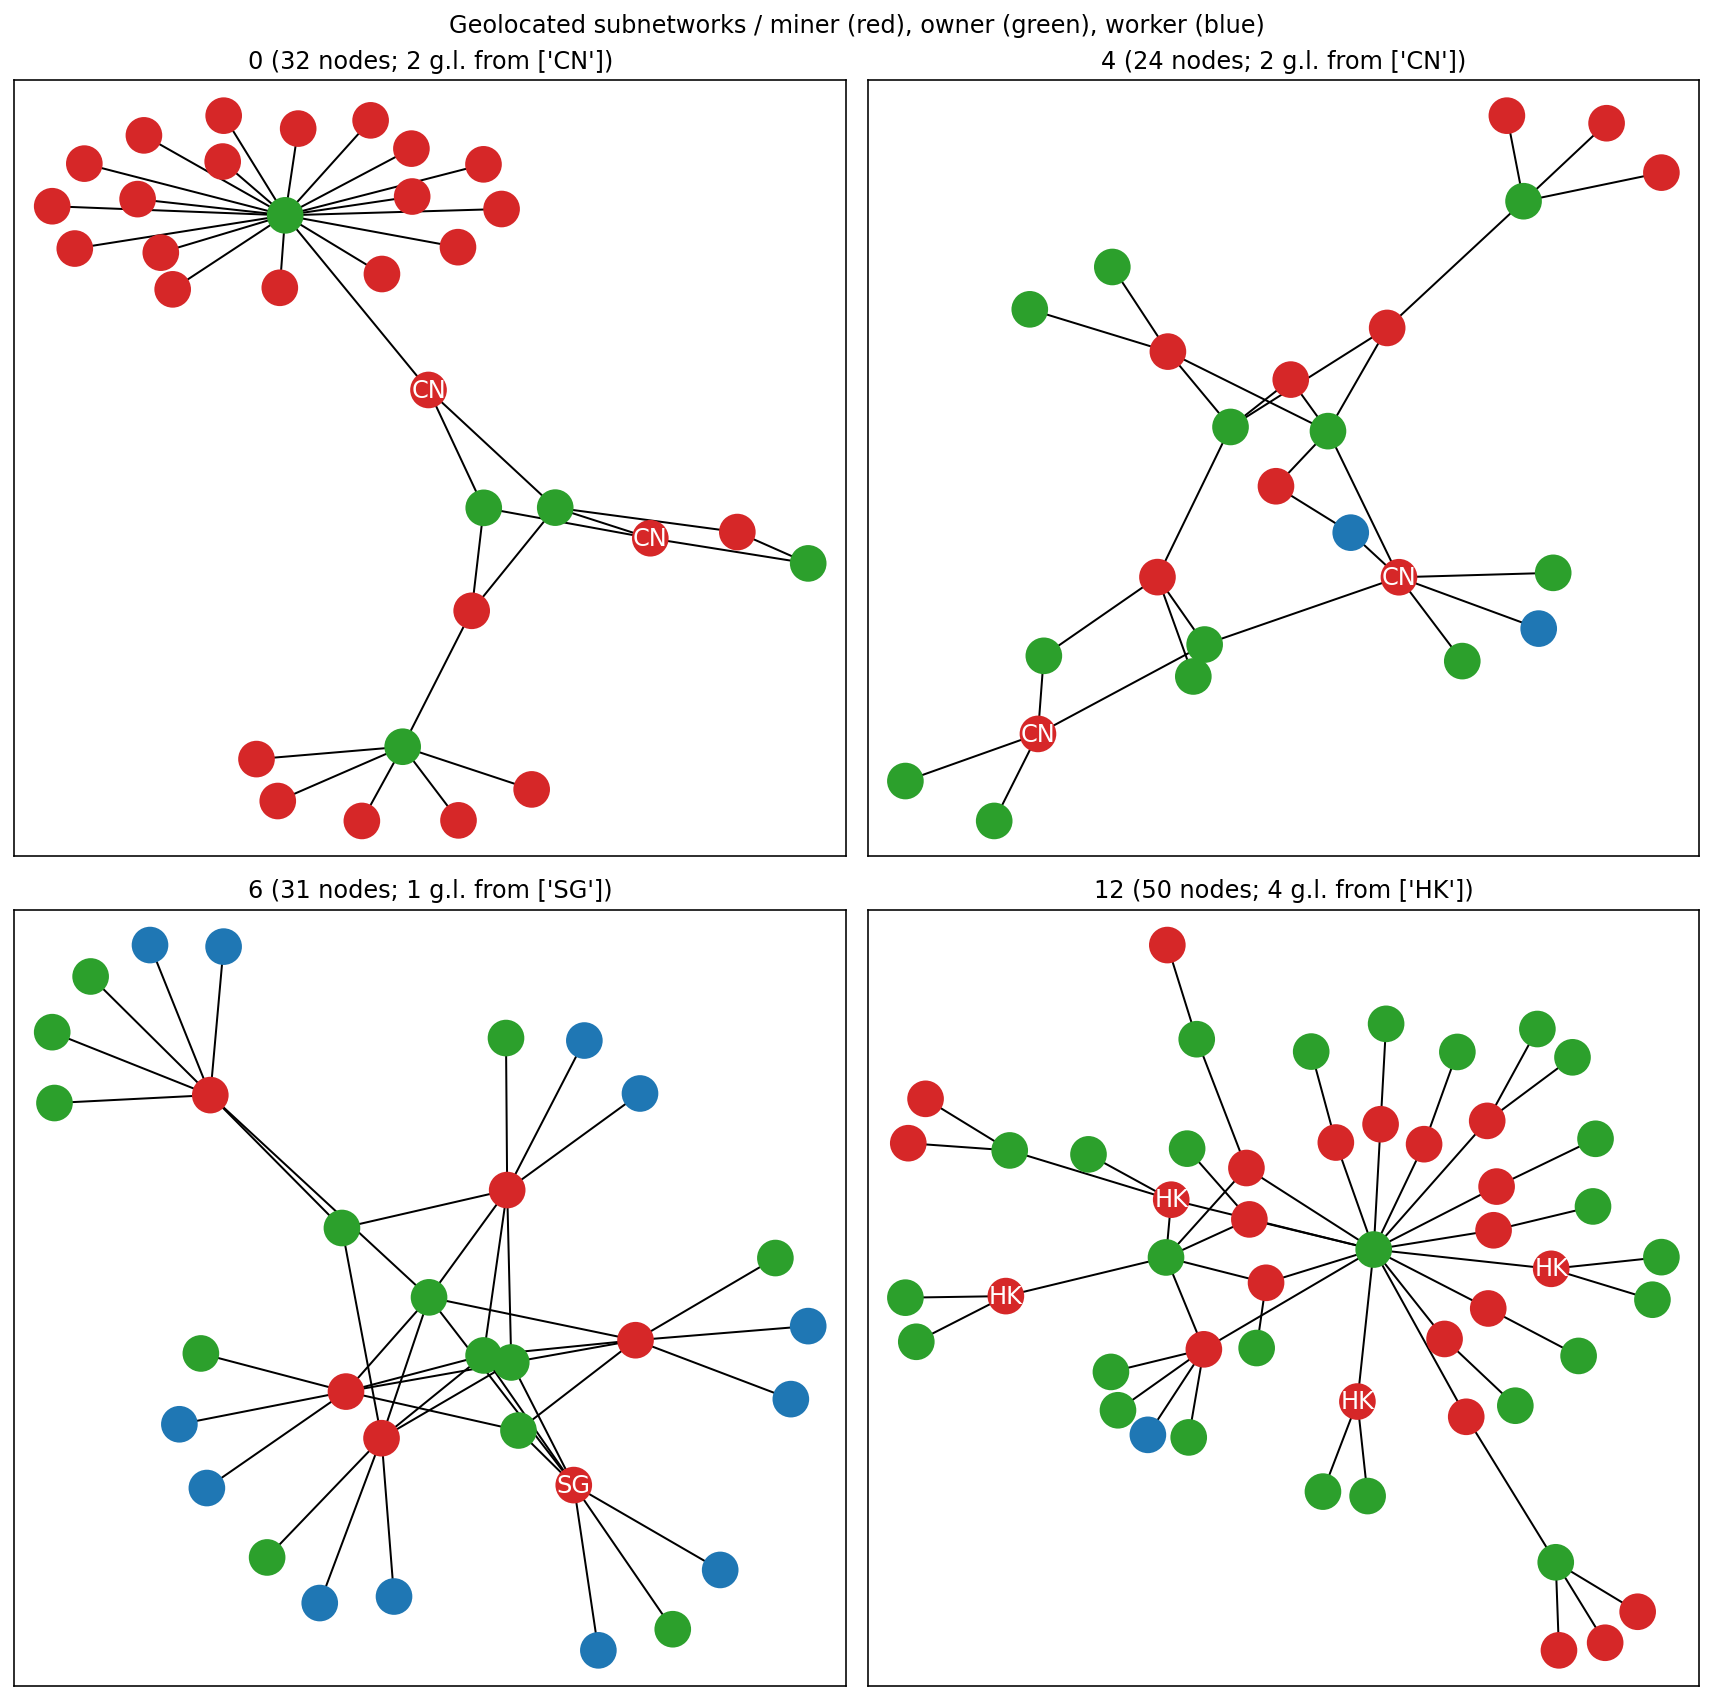

In [5]:
plot_geolocated_subgraphs(data, n_rows=2)

### 2. Synthetic locations

The idea of synthetic locations comes from Jim Pick's [incredible collection of Observable notebooks](https://observablehq.com/collection/@jimpick/provider-quest). The idea is fairly simple. We can track, from chain data, how the network actors interact with one another (as shown above). The implication is that in a given subgraph, if many of the miners come from one country, we can probably say with reasonable confidence that *all* miners in the subgraph come from the same country. 

In [6]:
def countries_in_subgraph(G, subgraph_idx):
    '''
    Given a NetworkX subgraph, generates the list of countries seen. 

    Parameters
    ----------
    G (nx.Graph): the original graph
    subgraph_idx (int): index number of the graph component

    Returns
    -------
    num_nodes (int): number of nodes in the subgraph
    all_countries (list): list of all countries seen in the subgraph
    '''
    subgraphs = [nx.subgraph(G,c) for c in nx.connected_components(G)]
    k = subgraphs[subgraph_idx]
    # k = subgraph_list[subgraph_idx]
    all_countries = []
    all_nodes = []
    num_nodes = len(k.nodes)
    for node in k.nodes(data=True):
        all_nodes.append(node[0])
        try:
            if str(node[1]['country']) != 'nan':
                all_countries.append(node[1]['country'])
        except:
            pass
    return num_nodes, all_countries, all_nodes

In [7]:
subgraphs = [nx.subgraph(G,c) for c in nx.connected_components(G)]
number_of_subgraphs = len(subgraphs)
n_node_list = []
mode_country_list = []
n_geolocated_list = []
full_node_list = []

for n in tqdm(range(number_of_subgraphs)):
    n_nodes, all_c, all_nodes = countries_in_subgraph(G, n)
    n_node_list.append(n_nodes)
    full_node_list.append(all_nodes)
    if len(all_c) > 0:
        mode_country_list.append(stats.mode(all_c).mode[0])
    else: 
        mode_country_list.append('None')
    n_geolocated_list.append(len(all_c))

geo_df = pd.DataFrame(np.array([n_node_list, mode_country_list, n_geolocated_list, full_node_list]).T, 
                      columns=['num_nodes', 'mode_country', 'num_geolocated_nodes', 'associated_nodes'])    
geo_df.num_geolocated_nodes = pd.to_numeric(geo_df.num_geolocated_nodes)
geo_df.num_nodes = pd.to_numeric(geo_df.num_nodes)

 25%|██▌       | 200/800 [02:15<06:47,  1.47it/s]


KeyboardInterrupt: 

In [16]:
geo_df[geo_df.num_geolocated_nodes > 0].sort_values(by='num_geolocated_nodes', ascending=False)

,num_nodes,mode_country,num_geolocated_nodes,associated_nodes
186,155,CN,19,"[f079501, f079497, f058347, f023865, f01629723..."
13,994,SG,18,"[f01622180, f01807495, f01020274, f0410210, f0..."
136,37,SG,15,"[f02605, f018776, f01303, f073628, f0160135, f..."
150,23,DE,14,"[f020630, f015801, f015805, f015803, f015798, ..."
214,1485,AU,9,"[f01493622, f01492025, f01486551, f01494473, f..."
...,...,...,...,...
313,13,US,1,"[f014642, f01280, f0117459, f014645, f01083, f..."
311,51,CN,1,"[f01834162, f01714730, f094465, f01864131, f01..."
302,20,CN,1,"[f0705572, f0705577, f0705571, f0524567, f0721..."
300,17,CN,1,"[f092582, f0825574, f0506870, f0121432, f03452..."


In [26]:
geo_df[geo_df.num_geolocated_nodes > 0].iloc[-6].associated_nodes

['f01880052',
 'f01922654',
 'f01836690',
 'f01906078',
 'f01941091',
 'f01797256',
 'f01829758',
 'f02422',
 'f02310',
 'f01926496']

In [19]:
geo_df['num_geolocated_nodes'].sum() / len(data), geo_df['num_nodes'].sum() / len(data)

(0.0007542066526228186, 0.9513715508049205)

This shows the power of "synthetic locations" - we go from locating a fraction of 1% of the nodes, to having some inclination of where 95% of the nodes might be located.

### Global distribution of nodes

Now that we know the detailed network structure we can in principle geolocate a much larger swathe of the network than we could initially, based on the possibly questionable working assumption that if many miners in the same subgraph are from one country then the others probably also are. Now let us explore this possibility in detail.

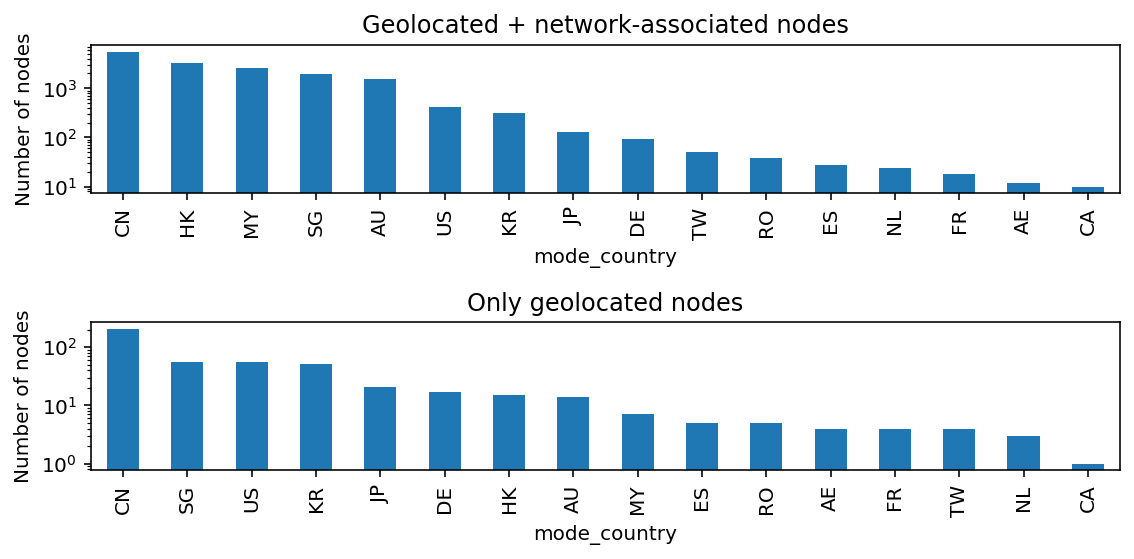

In [10]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,4))
geo_df[geo_df.mode_country != 'None'].groupby('mode_country').sum()['num_nodes'].sort_values(ascending=False).plot(kind='bar', ax=ax1)
geo_df[geo_df.mode_country != 'None'].groupby('mode_country').sum()['num_geolocated_nodes'].sort_values(ascending=False).plot(kind='bar', ax=ax2)
ax1.set_title('Geolocated + network-associated nodes')
ax2.set_title('Only geolocated nodes')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylabel('Number of nodes')
ax2.set_ylabel('Number of nodes')
plt.tight_layout()

Whether or not we use synthetic locations, the principal conclusions don't actually change -- the global supply of miner nodes is heavily skewed towards Asia. However, network geolocation would allow us to tag a much larger portion of the on-chain data. 

An interesting consequence of our network geolocation exercise is that the global distribution is less skewed to Asia than widely believed, with significant historical activity in places such as Australia and the United States. Clearly this conclusion might possibly be spurious and could also be prone to IP spoofing (or use of a VPN), so should be taken with an appropriate grain of salt. It would also be interesting to understand the *dynamic* distribution but by using the entire history of chain data to infer synthetic locations. 

### Important hubs

Here I visualise one subgraph, but size the nodes according to centrality. 

In [8]:
subgraphs = [nx.subgraph(G,c) for c in nx.connected_components(G)]
k = subgraphs[0]

In [37]:
hub_by_dc = pd.DataFrame.from_dict(nx.degree_centrality(k), orient='index').sort_values(by=0, ascending=False).iloc[0].name
hub_by_cc = pd.DataFrame.from_dict(nx.closeness_centrality(k), orient='index').sort_values(by=0, ascending=False).iloc[0].name
hub_by_ec = pd.DataFrame.from_dict(nx.eigenvector_centrality(k), orient='index').sort_values(by=0, ascending=False).iloc[0].name
hub_by_kc = pd.DataFrame.from_dict(nx.katz_centrality(k), orient='index').sort_values(by=0, ascending=False).iloc[0].name
print("Hub by degree centrality, %s"% hub_by_dc)
print("Hub by closeness centrality, %s"% hub_by_cc)
print("Hub by eigenvector centrality, %s"% hub_by_ec)
print("Hub by Katz centrality, %s"% hub_by_kc)

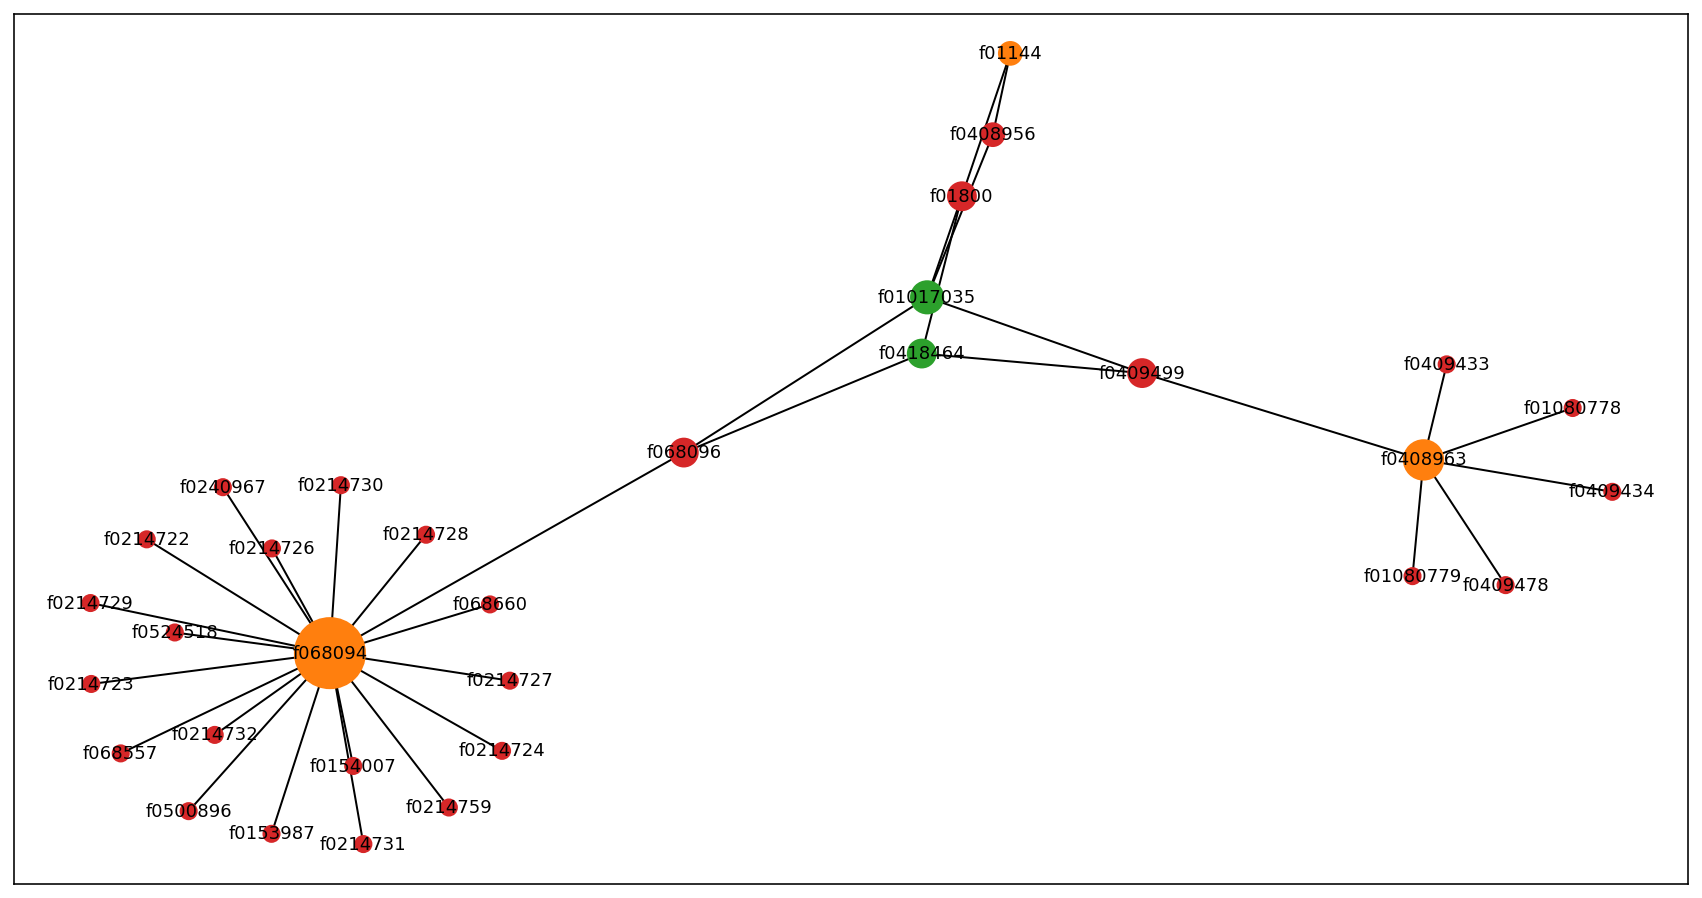

In [50]:
color_map = []
size_map = []
ndc = nx.degree_centrality(k)
for node in k.nodes:

    # Size the nodes by centrality
    size_map.append(ndc[node]*2000)

    if node in data.miner_id.values:
        color_map.append('C3')
    else:
        if (node in data.owner_id.values) and (node in data.worker_id.values):
                color_map.append('C1')
        else:
            if node in data.owner_id.values:
                color_map.append('C2')
            else:
                color_map.append('C0')

plt.figure(figsize=(15,8))
pos = nx.spring_layout(k)
grafo_labels = nx.get_edge_attributes(k,'weight')
nx.draw_networkx_nodes(k, pos, node_color=color_map, node_size=size_map)
nx.draw_networkx_edges(k, pos)
nx.draw_networkx_labels(k, pos, font_size=9)

edges_label = nx.draw_networkx_edge_labels(k, pos, edge_labels = grafo_labels)

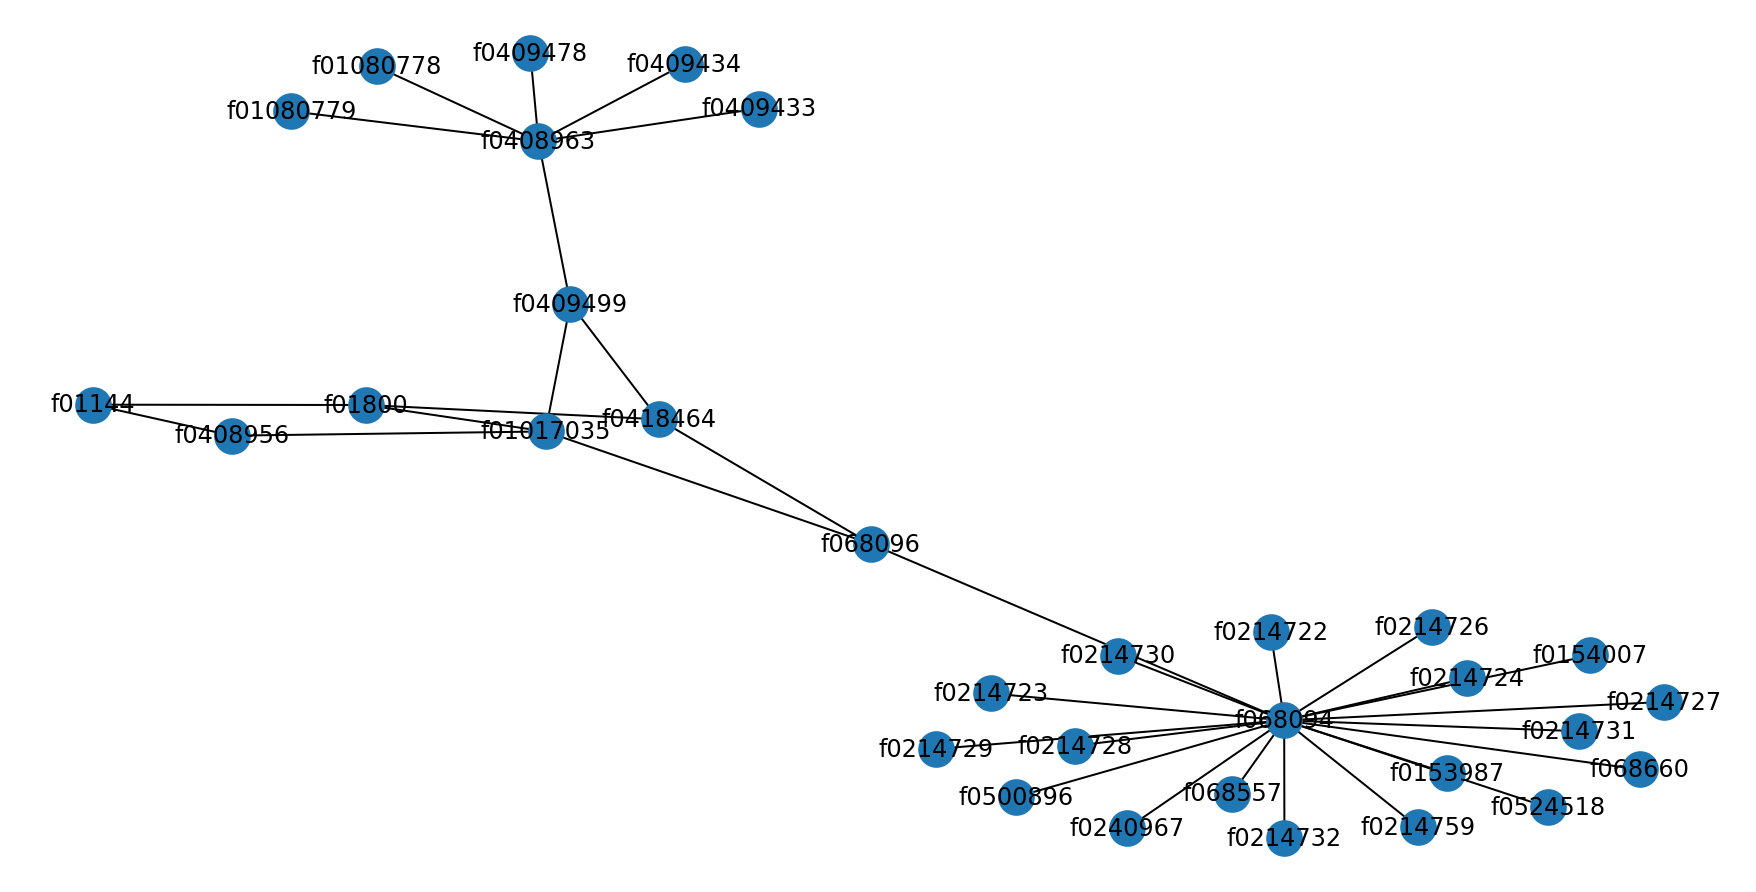

In [24]:
plt.figure(figsize=(12,6))
nx.draw(k, with_labels=True)